# Epidemics on networks: the SIS model
The goal of this simulation is to implement a working SIS (Susceptible-Infected-Susceptible) model and investigate the different properties of random and scale-free networks under the model. 

In the SIS model we expect the percentage of infected nodes in the network to eventually reach an equilibrium between the countervailing forces of new infections (a rate expressed as parameter _beta_) and recovery to susceptibility (a rate expressed as parameter _mu_).

## Methods

Since the characteristics of scale-free and random networks diverge as size increases, I experimented with several optimizations to facilitate creating large graphs. After a several minute warm-up, the code presented here is able to create graphs of 25,000 nodes in just a few seconds. This would represent the population of a small city. For the simulation I created 5 random (Erdos-Renyi) and 5 scale-free graphs.

Initial simulations of several scenarios over a timespan of 50 units rarely reached equilibrium. Therefore I heavily optimized the SIS simulation code, using a numpy array to hold the state for all nodes over the course of the simulation. These optimizations enabled simulations that could cover much longer time spans and thus reach equilibrium. I have provided comments in the code indicating the specific optimizations for creating graphs and conducting simulations.

The seed of infected population was set at 0.1% (25 individuals in a population of 25,000)--large enough to seed the epidemic process that would naturally occur under the parameters, but small enough to yield valid measurements of time to equilibrium.

I serialized the experimental output by copying the console/stdout and pasting into CSV files.

## Results and Discussion

### Epidemic Theshold

The epidemic threshold is the ratio of beta (infection rate) to mu (recovery to susceptible state) at which the contagion persists in a population. The ratio is expressed as parameter _lambda_. According to theory [Barabasi, Network Science, p. 394], _lambda_ has the following values as network size goes to infinity:
+ For random networks: `1 / (<k> + 1)`, where `<k>` represents average degree
+ For scale-free networks: `0`

The stunning prediction of inevitable contagion persistence in a scale-free network can be attributed to the presence of large hubs. Once a large hub is infected, it enters a perpetual cycle of infectig numerous neighbors, then being reinfected by those neighbors once it recovers to the susceptible state. In addition, the friendship paradox guarantees that hubs will be quickly reached from the seed population of infected nodes. 

See the next-to-last cell in this notebook for a visualization of the relationship between lambda and the epidemic threshold in these simulations. 

#### Random Network Epidemic Threshold
Since <k> = 4.38 for the random graphs in this simulation, the theoretical epidemic threshold is 1 / (4.38 + 1) = 0.186. The actual epidemic threshold in these simulations was 0.21. The slight difference from theory is likely due to the fact that the network population is only 25,000 rather than infinite.

#### Scale-Free Network Epidemic Threshold
The epidemic threshold for scale-free networks in these simulations was 0.018--not quite zero, but remarkably lower than the threshold for random networks. Given sufficient computing resources, simulations over larger populations would no doubt move the threshold into the territory of the infinitesimal.

### Time to Equilibrium
The visualization of time to equilibrium in the final cell of this notebook compares the average results for scale-free vs. random networks over several scenarios. Note that "equilibrium" is defined as the state in which the endemic contagion persists in a roughly stable portion of the population over time. Thus the comparison excludes any scenario in which one or both of the network types becomes contagion-free. For purposes of these simulations, the equilibrium infected portion of the population is deemed to be the average value of the final 25 observations in the time series.

Time to equilibrium is roughly four times larger for random networks than for scale-free networks. Equilibrium is reached much more quickly in a scale-free network because the hubs accelerate progress toward the equilibrium condition.




In [34]:
import networkx as nx
import numpy as np
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
def create_rn_graph(num_nodes, density = None):
    '''
    adapted from code supplied in course I-590 Network Science, Spring 2018 (Indiana U)
    '''
    if not density:
        density = 4 / num_nodes
    rnd_graph = nx.erdos_renyi_graph(num_nodes, density)
    # We want to make sure that the graph is connected, so we will only take the largest
    # connected component, as disconnected parts can't be infected or transmit infection:
    return max(nx.connected_component_subgraphs(rnd_graph), key=len)

In [ ]:
degree_dict = {}
def create_undirected_sf_graph(n):
    '''
    Returns a graph with n vertices having a power-law degree distribution with gamma ~ 2.5
    '''
    # networkx.scale_free_graph() is very time-consuming for large graphs; it requires several minutes for a
    # graph with 25,000 nodes. On the other hand, configuration_model() runs very quickly once it has a degree distribution.
    # So we use scale_free_graph to initialize the degree distribution, then we use configuration_model() on all subsequent
    # graphs with the same number of nodes.
    if not n in degree_dict:
        sf_dir = nx.scale_free_graph(n, alpha=0.35, beta=0.60, gamma=0.05, delta_in=0.4, delta_out=0.4)
        sf_undir = sf_dir.to_undirected()
        degrees = list(dict(sf_undir.degree()).values())
        degree_dict[n] = degrees
    gr = nx.configuration_model(degree_dict[n])
    gr = nx.Graph(gr) # removes parallel edges
    gr.remove_edges_from(gr.selfloop_edges()) # removes self-loops
    return gr
   

In [ ]:
def SIS(graph, tmax, beta, initial_inf, mu):
    '''
    graph - networkx undirected graph
    tmax - number of time cycles
    beta - transmission probability from susceptible (S) to infected (I)
    initial_inf - initial fraction of infected nodes
    mu - probability of recovery from infected (I) to susceptible (S)
    
    Returns - a list of tmax floats whose values are the infected percentage at each time t
    '''
    neighbors = defaultdict(list) # so that nodes with no neighbors will have an empty list by default
    nodes = graph.nodes()
    for node in nodes:
        neighbors[node] = list(graph.neighbors(node))
    num_nodes = len(nodes)
    
    # In a random graph, some of the nodes may have been unconnected and therefore removed
    # We will have to create empty rows to represent any removed nodes
    max_nodeid = max(nodes)
    
    # create state array with dimensions nodes x tmax+1; value of 0 = susceptible, 1 = infected
    disease = np.zeros((max_nodeid + 1, tmax + 1), dtype=np.uint8) 
    
    # initialize the array of infected at time 0
    infected_0 = np.random.choice(nodes, size=int(num_nodes * initial_inf), replace=False)
    disease[infected_0,0] = 1
    
    # set nodes to 0 or 1 at each time t based on params + probabilities. We are using a synchronized time-series model
    # with simultaneous updates from time t - 1 to time t
    for t in range(1, tmax+1):
        infected = disease[:, t-1].nonzero()[0] # array of indices of infected at time t-1
        susceptible = np.where(disease[:, t-1] == 0)[0] # array of indices of susceptible at time t-1
        for s in susceptible:
            num_infected_neighbors = np.sum(disease[neighbors[s], t-1])
            if np.random.random() < (1 - (1 - beta)**num_infected_neighbors):
                disease[s,t] = 1
        for i in infected:
            if np.random.random() > mu:
                # did not recover
                disease[i, t] = 1
    # multiply infected %-age by (maxnodeid + 1) / num_nodes to compensate for empty rows
    return np.mean(disease, axis = 0) * (max_nodeid + 1) / num_nodes

In [ ]:
init_infected = .001   # 1/1000 of population infected at t0 (25 out of 25,000)
tmax = 250             # 250 time units to make sure the simulation reaches equilibrium
def calc_disease_props(infected_percent):
    '''
    Returns a tuple (equilibrium, t at which equilibrium established) 
    '''
    equilibrium = np.mean(infected_percent[-25:])
    if equilibrium < init_infected:
        t_equilibrium = 0
    else:
        t_equilibrium = np.nonzero(infected_percent > equilibrium)[0][0]
    return equilibrium, t_equilibrium

In [ ]:
nodes = 25000
density = 0.000175 # derived empirically from properties of scale-free graphs with 25,000 nodes
rngraphs = []
sfgraphs = []
for _ in range(5):
    rngraphs.append(create_rn_graph(nodes, density))
    sfgraphs.append(create_undirected_sf_graph(nodes))
print("graphs created")

betas = [.05,.10]
mus = [x/100 for x in range(10, 82, 2)] # .10 to .80, by .02
rn_results = []
sf_results = []
print("graph_type,beta,mu,equilibrium,t_equilibrium")
for beta in betas:
    for mu in mus:
        eq, t_eq = np.mean([calc_disease_props(SIS(g, tmax, beta, init_infected, mu)) for g in rngraphs], axis = 0)
        result = ["er",beta,mu,eq,t_eq]
        print(",".join(str(e) for e in result))
        rn_results.append(result)
        eq, t_eq = np.mean([calc_disease_props(SIS(g, tmax, beta, init_infected, mu)) for g in sfgraphs], axis = 0)
        result = ["sf",beta,mu,eq,t_eq]
        print(",".join(str(e) for e in result))
        sf_results.append(result)
np.save("rn_results.npy", np.array(rn_results))
np.save("sf_results.npy", np.array(sf_results))


In [ ]:
beta = .05
mu = .23
eq, t_eq = np.mean([calc_disease_props(SIS(g, tmax, beta, init_infected, mu)) for g in rngraphs], axis = 0)
result = ["er",beta,mu,eq,t_eq]
print(",".join(str(e) for e in result))
rn_results.append(result)
eq, t_eq = np.mean([calc_disease_props(SIS(g, tmax, beta, init_infected, mu)) for g in sfgraphs], axis = 0)
result = ["sf",beta,mu,eq,t_eq]
print(",".join(str(e) for e in result))
sf_results.append(result)


In [ ]:
betas = [x/1000 for x in range(21, 0, -1)]
mu = 0.5
for beta in betas:
    eq, t_eq = np.mean([calc_disease_props(SIS(g, tmax, beta, init_infected, mu)) for g in sfgraphs], axis = 0)
    result = ["sf",beta,mu,eq,t_eq]
    print(",".join(str(e) for e in result))
    sf_results.append(result)
    

In [ ]:
beta = .02
mu = .5
eq, t_eq = np.mean([calc_disease_props(SIS(g, tmax, beta, init_infected, mu)) for g in sfgraphs], axis = 0)
result = ["sf",beta,mu,eq,t_eq]
print(",".join(str(e) for e in result))



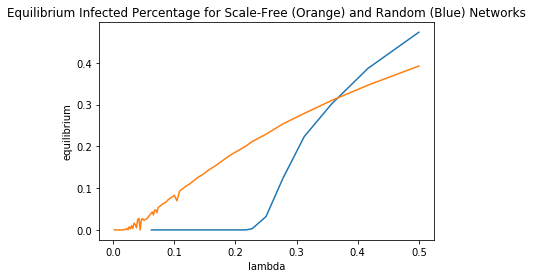

In [37]:
# load the saved results for equilibrium vs. lambda
equilibrium_col = 3
equilibrium_t_col = 4
lambda_col = 5
erdosrenyi_file = "er_results.csv"
er_results = np.loadtxt(erdosrenyi_file, delimiter = ',',skiprows = 1, usecols = (equilibrium_col, lambda_col, equilibrium_t_col))
scalefree_file = "sf_results.csv"
sf_results = np.loadtxt(scalefree_file, delimiter = ',',skiprows = 1, usecols = (equilibrium_col, lambda_col, equilibrium_t_col))

# plot equilibrium against lambda
plt.ylabel("equilibrium")
plt.xlabel("lambda")
plt.plot(er_results[:,1], er_results[:,0], label = 'er')
plt.plot(sf_results[:,1], sf_results[:,0], label = 'sf')
plt.title("Equilibrium Infected Percentage for Scale-Free (Orange) and Random (Blue) Networks")

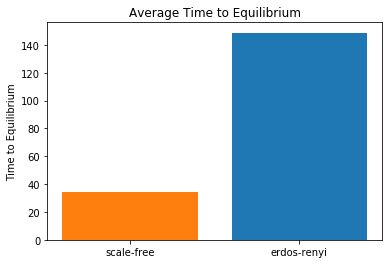

In [33]:
# plot bar graph for time to equilibrium

# observations where erdos-renyi network had reached 0.0 infection are not meaningful. 
# Exclude them from the calculations of equilibrium_t 
er_meaningful_lambda = er_results[er_results[:,0] > 0,1]
er_equilibrium_t = np.mean(er_results[er_results[:,0] > 0, 2])
sf_equilibrium_t = np.mean(sf_results[sf_results[:,1] >= min(er_meaningful_lambda), 2])

# build the plot
fig, ax = plt.subplots()
ind = np.arange(1, 3)
sf, er = plt.bar(ind, (sf_equilibrium_t, er_equilibrium_t))
sf.set_facecolor('tab:orange')
er.set_facecolor('tab:blue')
ax.set_xticks(ind)
ax.set_xticklabels(['scale-free', 'erdos-renyi'])
ax.set_ylabel('Time to Equilibrium')
ax.set_title('Average Time to Equilibrium')
